$$\Large \textit{Programacion para el Analisis Exploratorio de Datos}$$

$$\large\textbf{Trabajo Final}$$

$$\large\textbf{Recomendador de amigos en Redes Sociales}$$

_Integrantes del Equipo 5:_
*   Josmell Córdova Claros
*   Robert Humberto Pinedo Pimentel
*   Ricardo Cornejo Zuta
*   Joel Soria Campo
*   Manuel Martinez Zuasnabar

**Origen de los Datos**

El dataset utilizado en este estudio proviene de la Universidad de Stanford y consiste en datos de redes sociales recopilados de Facebook. Los datos fueron obtenidos a través de una aplicación de Facebook diseñada para recolectar información de los participantes mediante encuestas. Este conjunto de datos incluye características de los nodos (perfiles), círculos (o listas de amigos), y redes ego (usuario principal cuya red de conexiones se está estudiando).

Datos obtenidos de: https://snap.stanford.edu/data/ego-Facebook.html

**Definición de los Datos**

Los datos de Facebook han sido anonimizados, reemplazando los identificadores internos de Facebook para cada usuario con nuevos valores. Además, aunque se han proporcionado vectores de características de este dataset, la interpretación de estas características ha sido obscurecida. Por ejemplo, donde el conjunto de datos original podría haber contenido una característica como "política=Partido Demócrata", los nuevos datos simplemente contienen "política=característica anonimizada 1". Por lo tanto, es posible determinar si dos usuarios comparten las mismas afiliaciones políticas, pero no identificar cuáles son esas afiliaciones individuales.

Los archivos (datos) proporcionados por la página de Standford son los siguientes:

-".edges": Contiene las conexiones entre los amigos del nodo ego, representando la estructura de la red social. El nodo ego en sí no aparece en este archivo, pero se asume que está conectado con todos los nodos presentes en el archivo.

-".feat": Contiene las características de los nodos (excepto el nodo ego), con valores binarios.

-".egofeat": Contiene las características del nodo ego.

-".featnames": Contiene los nombres de las características, correspondientes a las columnas en los archivos ".feat" y ".egofeat".

-".circles": Contiene los grupos de amigos del nodo ego, con cada línea representando un círculo.

**Estadísticas del Dataset**

Nodos: 4039

Aristas: 88234

Nodos en el mayor componente débilmente conectado: 4039 (1.000)

Aristas en el mayor componente débilmente conectado: 88234 (1.000)

Nodos en el mayor componente fuertemente conectado: 4039 (1.000)

Aristas en el mayor componente fuertemente conectado: 88234 (1.000)

Coeficiente de agrupamiento promedio: 0.6055

Número de triángulos: 1612010

Fracción de triángulos cerrados: 0.2647

Diámetro (camino más largo más corto): 8

Diámetro efectivo del 90 percentil: 4.7

**Contexto**

En el contexto actual de las redes sociales, donde la interacción entre usuarios es esencial para la retención y el crecimiento de la plataforma, la recomendación de amigos se convierte en una función crucial. Las plataformas de redes sociales, como Facebook, buscan constantemente mejorar la experiencia del usuario mediante la introducción de nuevas conexiones relevantes. Estas conexiones no solo aumentan la actividad en la plataforma sino que también mejoran la satisfacción del usuario.

**Problema a Resolver o Analizar**

El problema que este estudio busca resolver es la identificación de asociaciones entre usuarios en una red social y la generación de recomendaciones de amigos, se pretende:

-Identificar patrones relevantes en las conexiones de la red social.

-Generar recomendaciones de amigos que sean significativas y útiles para los usuarios.

-Mejorar la cohesión y la interacción dentro de la red social, incrementando así la retención y el engagement de los usuarios.

En este estudio, se analizará la estructura de los grafos y se utilizará el algoritmo Apriori para analizar las reglas de asociación en la red social y poder generar recomendaciones de amigos, además de visualizar estas asociaciones mediante grafos, donde se destacan las posibles nuevas conexiones entre distintos usuarios. Este enfoque no solo ayuda a entender mejor la estructura de la red social, sino que también proporciona una herramienta efectiva para la recomendación de amigos.

## Análisis inicial exploratorio de datos

Por tratarse de datos del tipo grafos, no se tienen problemas de consistencia con los datos; es decir, no se cuentan con valores duplicados o nulos. Por lo tanto, el análisis se basará más en el análisis de la cantidad y tipos de datos (edges, circles, feat, featname y egofeat).

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [282]:
# Función para leer archivos edges

def read_edges(file_path):
    G = nx.read_edgelist(file_path, nodetype=int)
    return G

# Función para leer archivos circles

def read_circles(file_path):
    circles = {}
    with open(file_path, "r") as f:
        for line in f:
            circle = line.strip().split()
            circle_name = circle[0]
            members = list(map(int, circle[1:]))
            circles[circle_name] = members
    return circles

# Función para leer archivos feat

def read_feat(file_path):
    df = pd.read_csv(file_path, sep=' ', header=None)
    df.index = df.loc[:,0]
    df.drop(columns = 0, inplace = True)
    
    return df

# Función para leer archivos egofeat

def read_egofeat(file_path):
    num_cols = len(pd.read_csv(file_path, sep=' ').columns)
    nombre_columnas = list(range(1, num_cols +1))
    return pd.read_csv(file_path, sep=' ', names = nombre_columnas).iloc[0]

# Función para leer archivos featnames

def read_featnames(file_path):
    featnames = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()[line.find(" ")+1:]
            line = line.replace(";", " ")
            line = line.replace("id","")
            line = line.replace("anonymized feature", "")
            line = line.replace("   "," ")
            line = line.replace("  "," ")
            featnames.append(line)
    return featnames

# Función necesaria para plotear el grafo

def plot_graph(G, weight_name=None):
    
    #%matplotlib notebook
    import matplotlib.pyplot as plt

    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = None

    if weight_name:
        weights = [int(G[u][v][weight_name]) for u,v in edges]
        labels = nx.get_edge_attributes(G,weight_name)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        nx.draw_networkx(G, pos, width=weights);
    else:
        nx.draw_networkx(G, pos,);

# Función para crear dataframe de los feats

def create_combined_dataframe(feat, egofeat, featnames):
    df = feat.copy()
    df.columns = featnames
    ego_df = pd.DataFrame([egofeat])
    ego_df.columns = featnames
    ego_df["node"] = "ego"
    df["node"] = df.index
    combined_df = pd.concat([ego_df, df])
    return combined_df

Lectura de datos

In [219]:
node_ids = ["0", "107", "348", "414", "686", "698", "1684", "1912", "3437", "3980"]

# Diccionarios para almacenar las lecturas de datos
feat_dict = {}
egofeat_dict = {}
featnames_dict = {}
edges_dict = {}
circles_dict = {}

# Lectura de datos por cada nodo ego
for i in node_ids:
    feat = read_feat("./facebook/" + i + ".feat")
    egofeat = read_egofeat("./facebook/" + i +".egofeat")
    featname = read_featnames("./facebook/" + i + ".featnames")
    edge = read_edges("./facebook/" + i + ".edges")
    circle = read_circles("./facebook/" + i + ".circles")
    
    feat_dict[i] = feat
    egofeat_dict[i] = egofeat
    featnames_dict[i] = featname
    edges_dict[i] = edge
    circles_dict[i] = circle

Análisis de las conexiones de los usuarios por cada red de los nodos egos (Edges):

In [220]:
# Verificar conexiones y usuarios en los grafos
for node in node_ids:
    edge_list = list(edges_dict[node].edges)
    user_list = list(edges_dict[node].nodes)
    print("Número de usuarios totales para el nodo ego {}: {}".format(node, len(user_list)))
    print("Número de conexiones totales para el nodo ego {}: {}".format(node, len(edge_list)))
    print("\n")

Número de usuarios totales para el nodo ego 0: 333
Número de conexiones totales para el nodo ego 0: 2519


Número de usuarios totales para el nodo ego 107: 1034
Número de conexiones totales para el nodo ego 107: 26749


Número de usuarios totales para el nodo ego 348: 224
Número de conexiones totales para el nodo ego 348: 3192


Número de usuarios totales para el nodo ego 414: 150
Número de conexiones totales para el nodo ego 414: 1693


Número de usuarios totales para el nodo ego 686: 168
Número de conexiones totales para el nodo ego 686: 1656


Número de usuarios totales para el nodo ego 698: 61
Número de conexiones totales para el nodo ego 698: 270


Número de usuarios totales para el nodo ego 1684: 786
Número de conexiones totales para el nodo ego 1684: 14024


Número de usuarios totales para el nodo ego 1912: 747
Número de conexiones totales para el nodo ego 1912: 30025


Número de usuarios totales para el nodo ego 3437: 534
Número de conexiones totales para el nodo ego 3437: 4813

In [221]:
# Guardamos cantidad de conexiones y usuarios por cada nodo ego para visualización

n_users = []
n_edges = []

for node in node_ids:
    n_users.append(len(list(edges_dict[node].nodes)))
    n_edges.append(len(list(edges_dict[node].edges)))

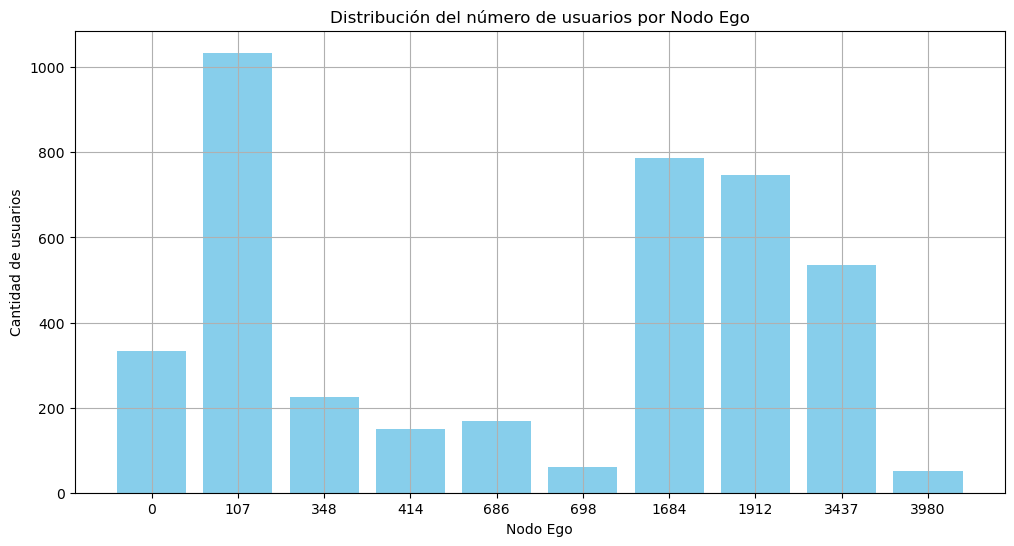

In [222]:
# Crear gráfica para la cantidad de usuarios
plt.figure(figsize=(12, 6))
plt.bar(node_ids, n_users, color='skyblue')
plt.title("Distribución del número de usuarios por Nodo Ego")
plt.xlabel("Nodo Ego")
plt.ylabel("Cantidad de usuarios")
plt.grid(True)
plt.show()

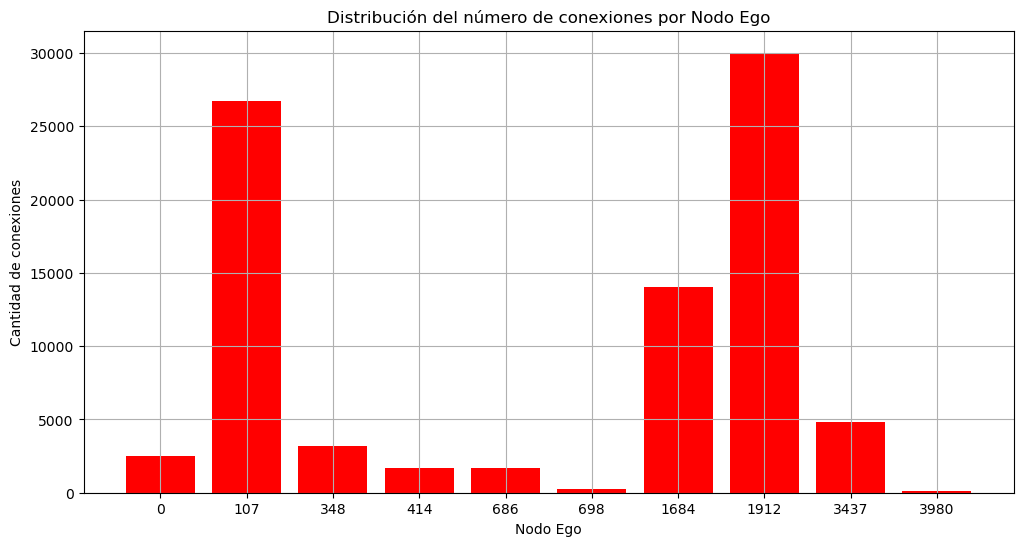

In [223]:
# Crear gráfica para la cantidad de conexiones
plt.figure(figsize=(12, 6))
plt.bar(node_ids, n_edges, color='red')
plt.title("Distribución del número de conexiones por Nodo Ego")
plt.xlabel("Nodo Ego")
plt.ylabel("Cantidad de conexiones")
plt.grid(True)
plt.show()

Análisis de cantidad de features para cada nodo ego

In [265]:
n_feat = [] # número de features por cada nodo ego
for i in node_ids:  
    print("El nodo ego {}, presenta {} features".format(i, egofeat_dict[i].value_counts()[1]))
    n_feat.append(egofeat_dict[i].value_counts()[1])
    # Buscamos las features que presenta cada nodo ego:
    pos_feat_ego = []
    for j in range(1, len(egofeat_dict[i]+1)):
        if egofeat_dict[i][j] == 1:
            pos_feat_ego.append(j)
        else:
            pass
    print("Siendo estas: ")
    for x in range(0, len(pos_feat_ego)):
        index = pos_feat_ego[x]
        print(featnames_dict[i][index])
    print("\n")

El nodo ego 0, presenta 30 features
Siendo estas: 
education classes 10
education concentration 15
education school 40
education school 51
education type 53
education type 54
education type 55
education with 56
education year 70
hometown 79
last_name 105
location 128
location 130
work employer 145
work employer 147
work employer 150
work employer 154
work end_date 158
work end_date 161
work end_date 164
work end_date 166
work location 173
work position 186
work position 189
work start_date 160
work start_date 197
work start_date 198
work start_date 199
work start_date 166
work start_date 171


El nodo ego 107, presenta 11 features
Siendo estas: 
birthday 6
education degree 434
education school 537
education type 53
education type 54
education type 55
education year 67
education year 71
hometown 558
last_name 593
locale 278


El nodo ego 348, presenta 21 features
Siendo estas: 
birthday 1
education school 229
education school 233
education type 53
education type 54
education type 55
edu

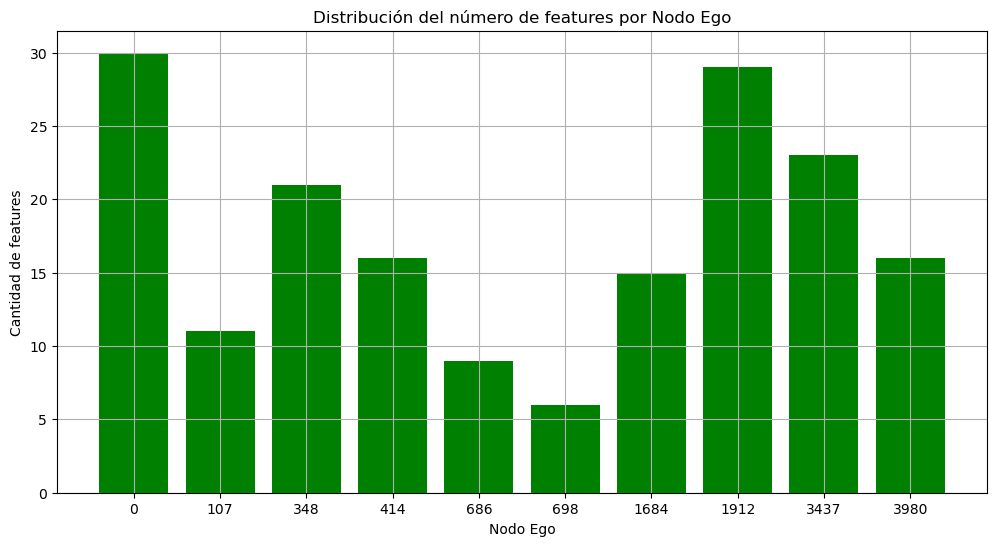

In [267]:
# Crear gráfica para la cantidad de features
plt.figure(figsize=(12, 6))
plt.bar(node_ids, n_feat, color='green')
plt.title("Distribución del número de features por Nodo Ego")
plt.xlabel("Nodo Ego")
plt.ylabel("Cantidad de features")
plt.grid(True)
plt.show()

Análisis de cantidad de círculos de amigos por cada nodo ego

In [271]:
n_circles = [] # número de círculos por cada nodo ego
for i in node_ids:  
    print("El nodo ego {}, presenta {} círculos de amigos".format(i, len(circles_dict[i])))
    n_circles.append(len(circles_dict[i]))

El nodo ego 0, presenta 24 círculos de amigos
El nodo ego 107, presenta 9 círculos de amigos
El nodo ego 348, presenta 14 círculos de amigos
El nodo ego 414, presenta 7 círculos de amigos
El nodo ego 686, presenta 14 círculos de amigos
El nodo ego 698, presenta 13 círculos de amigos
El nodo ego 1684, presenta 17 círculos de amigos
El nodo ego 1912, presenta 46 círculos de amigos
El nodo ego 3437, presenta 32 círculos de amigos
El nodo ego 3980, presenta 17 círculos de amigos


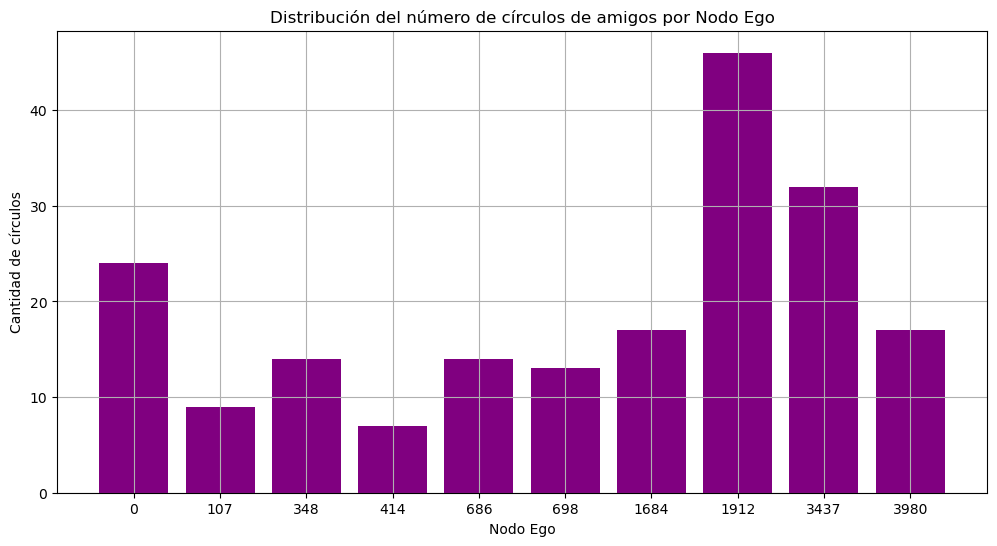

In [272]:
# Crear gráfica para la cantidad de círculos de amigos
plt.figure(figsize=(12, 6))
plt.bar(node_ids, n_circles, color='purple')
plt.title("Distribución del número de círculos de amigos por Nodo Ego")
plt.xlabel("Nodo Ego")
plt.ylabel("Cantidad de círculos")
plt.grid(True)
plt.show()

En resumen, se observa que los nodos con mayor actividad en la red social son: 107, 1684 y 1912, puesto que presentan mayor cantidad de amigos; por ende, también presentan la mayor cantidad de conexiones y de círculo de amigos.
Por otro lado, la cantidad de features que tiene cada nodo está distribuida de forma más homogenea, siendo los nodos: 0, 1912 y 3437 los que presentan la mayor cantidad.

## Asociación de usuarios en base a análisis de grafos

**Análisis de medidas de centralidad**

-Degree Centrality: Es la medida más básica de centralidad: número de amigos. Nodos importantes tienen muchas conexiones (persona más popular).

-Closeness Centrality: Los nodos con alta centralidad de cercanía son eficientes en la difusión de información a través de la red.

-Betweennness Centrality: Los nodos importantes conectan otros nodos. Importantes para la comunicación y transferencia de información. 

-Eigenvector Centrality: La importancia de un nodo está definida por la suma de importancia de sus vecinos.

In [291]:
import pandas as pd

In [312]:
centralities_dict = {} # diccionario para unir los df de centralities

for i in node_ids:
    degree_centrality = nx.degree_centrality(edges_dict[i])
    betweenness_centrality = nx.betweenness_centrality(edges_dict[i])
    closeness_centrality = nx.closeness_centrality(edges_dict[i])
    eigenvector_centrality = nx.eigenvector_centrality(edges_dict[i])

# Crear DataFrame para un mejor análisis
    centralities_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality,
    'Eigenvector Centrality': eigenvector_centrality,
    "User ego": i})

    centralities_dict[i] = centralities_df

In [315]:
centralities_f = pd.concat(centralities_dict.values())

In [323]:
centralities_f.shape # ya se tienen todas las métricas de todos los usuarios en un df

(4089, 5)

In [330]:
centralities_f.head()

,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,User ego
236,0.108434,0.003643,0.321313,0.092264,0
186,0.129518,0.005513,0.345703,0.128597,0
122,0.186747,0.022754,0.362868,0.165014,0
285,0.138554,0.013690,0.355078,0.130247,0
24,0.045181,0.000107,0.261434,0.003449,0


Relación entre la métrica de "Degree Centrality" y "Betweness Centrality"

C:\Users\rober\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\rober\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



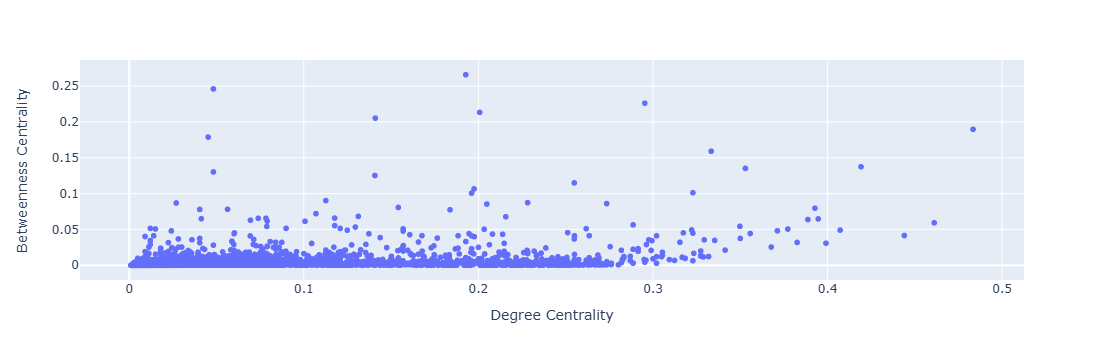

In [328]:
import plotly.express as px
fig = px.scatter(centralities_f, x='Degree Centrality', y='Betweenness Centrality', width=900, text=centralities_f.index)
fig.update_traces(textposition='top center')
fig.show()

No se observa una relación clara entre estas dos métricas; sin embargo, a partir de un Degree Centrality de 0.28, aprox, el Betweness Centrality tiende a crecer y no se queda estancado en valores bajos.

Relación entre la métrica de "Degree Centrality" y "Closeness Centrality"

C:\Users\rober\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\rober\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



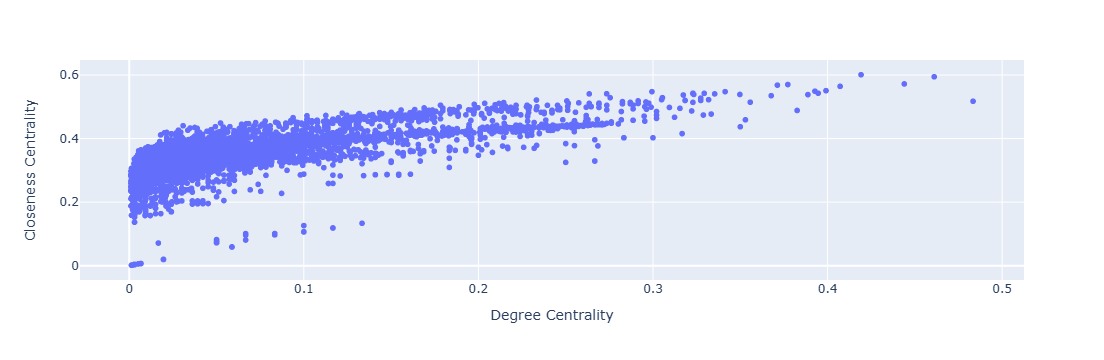

In [327]:
import plotly.express as px
fig = px.scatter(centralities_f, x='Degree Centrality', y='Closeness Centrality', width=900, text=centralities_f.index)
fig.update_traces(textposition='top center')
fig.show()

La gráfica muestra una clara tendencia positiva: a medida que la centralidad de grado aumenta, también lo hace la centralidad de cercanía. Esto tiene sentido, ya que los usuarios con más conexiones directas suelen estar más centralmente ubicados en la red y, por tanto, pueden alcanzar a otros usuarios de manera más eficiente.

Relación entre la métrica de "Degree Centrality" y "Eigenvector Centrality"

C:\Users\rober\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\rober\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



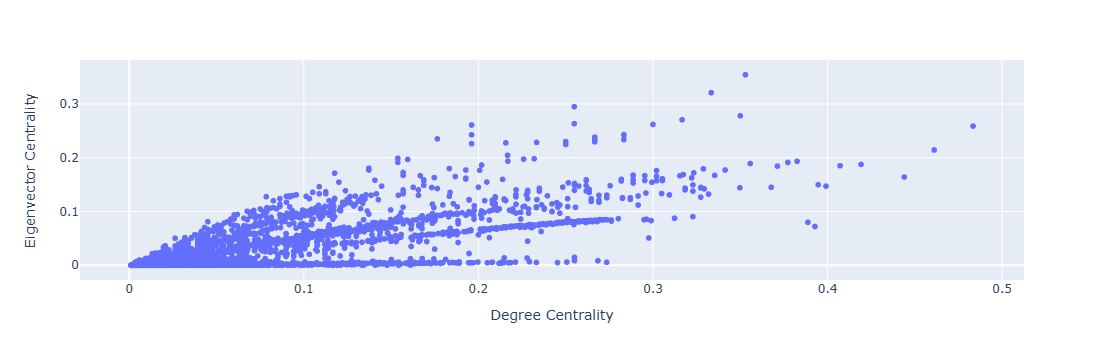

In [329]:
import plotly.express as px
fig = px.scatter(centralities_f, x='Degree Centrality', y='Eigenvector Centrality', width=900, text=centralities_f.index)
fig.update_traces(textposition='top center')
fig.show()

Existe una tendencia general positiva entre la centralidad por grado y la centralidad por eigenvector. A medida que aumenta la centralidad por grado, también tiende a aumentar la centralidad por eigenvector. 

Sin embargo, la dispersión indica que no todos los nodos con alta centralidad por grado tienen una alta centralidad por eigenvector. Esto sugiere que tener muchas conexiones directas (grado alto) no siempre se traduce en estar conectado a otros nodos igualmente influyentes (alta centralidad por eigenvector).

In [337]:
centralities_f.sort_values(by = "Degree Centrality", ascending = False).head(10)

,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,User ego
856,0.483333,0.189692,0.517347,0.258933,698
828,0.461078,0.059246,0.594306,0.214428,686
376,0.443946,0.041497,0.571795,0.164115,348
713,0.419162,0.137412,0.600719,0.187573,686
705,0.407186,0.049064,0.564189,0.185056,686
475,0.399103,0.030793,0.550617,0.147208,348
412,0.394619,0.064675,0.542579,0.149798,348
2543,0.392761,0.079560,0.548970,0.072086,1912
2347,0.388740,0.063832,0.538191,0.079828,1912
376,0.382550,0.031774,0.488306,0.193360,414


In [338]:
centralities_f.sort_values(by = "Eigenvector Centrality", ascending = False).head(10)

,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,User ego
4030,0.352941,0.135154,0.458923,0.354413,3980
4023,0.333333,0.159145,0.477038,0.321091,3980
3982,0.254902,0.036663,0.421569,0.294913,3980
747,0.350000,0.037395,0.437069,0.278013,698
828,0.316667,0.011184,0.415574,0.270561,698
3998,0.254902,0.114922,0.431606,0.263400,3980
823,0.300000,0.008988,0.402381,0.261962,698
3997,0.196078,0.006130,0.398406,0.260882,3980
856,0.483333,0.189692,0.517347,0.258933,698
774,0.283333,0.010571,0.402381,0.243031,698


Debido al contexto de red social, se tomarán como métricas principales de análisis el "Degree Centrality" y el "Eigenvector Centrality". Por lo tanto, se observan los 10 usuarios con mejor puntuación para cada caso, esos nodos son los más influyentes en sus respectivas redes ego.

De las 2 tablas, se observa que los usuarios 828 y 856 aparecen en ambas, indicando que son muy importantes en la red social.

In [343]:
# Gráfico para visualizar grafo alrededor de un nodo
import networkx as nx
import matplotlib.pyplot as plt
# Input: grafo, nodo que se desea visualizar y nivel de profundidad de visualización
# Output: Visualización del grafo
def visualizar_nodo_alrededor(grafo, nodo_id, niveles=1):

    # Comprobar si el nodo existe en el grafo
    if nodo_id not in grafo:
        raise ValueError(f"El nodo {nodo_id} no existe en el grafo")
    
    # Obtener nodos en la vecindad especificada
    nodos_vistos = set([nodo_id])
    nodos_actuales = set([nodo_id])
    
    for _ in range(niveles):
        nodos_siguientes = set()
        for nodo in nodos_actuales:
            vecinos = set(grafo.neighbors(nodo))
            nodos_siguientes.update(vecinos)
        nodos_actuales = nodos_siguientes - nodos_vistos
        nodos_vistos.update(nodos_siguientes)
    
    subgrafo = grafo.subgraph(nodos_vistos)

    # Preparar la coloración de los nodos
    color_map = []
    for nodo in subgrafo:
        if nodo == nodo_id:
            color_map.append('red')
        else:
            color_map.append('lightblue')
    
    # Dibujar el subgrafo
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgrafo)
    nx.draw(subgrafo, pos, with_labels=True, node_color=color_map, edge_color='gray', node_size=500, font_size=10)
    plt.show()

Visualización de nodos más influyentes de la red social

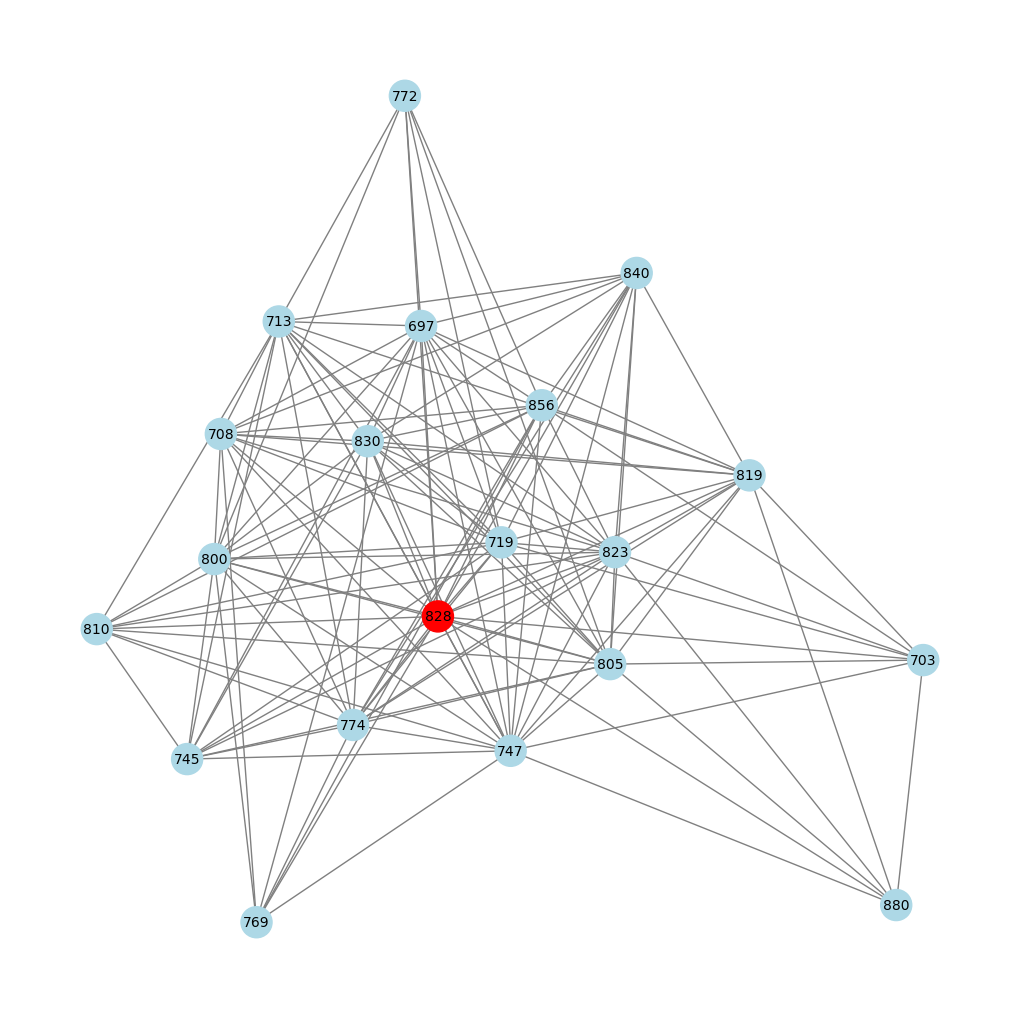

In [344]:
visualizar_nodo_alrededor(edges_dict["698"], 828, 1)

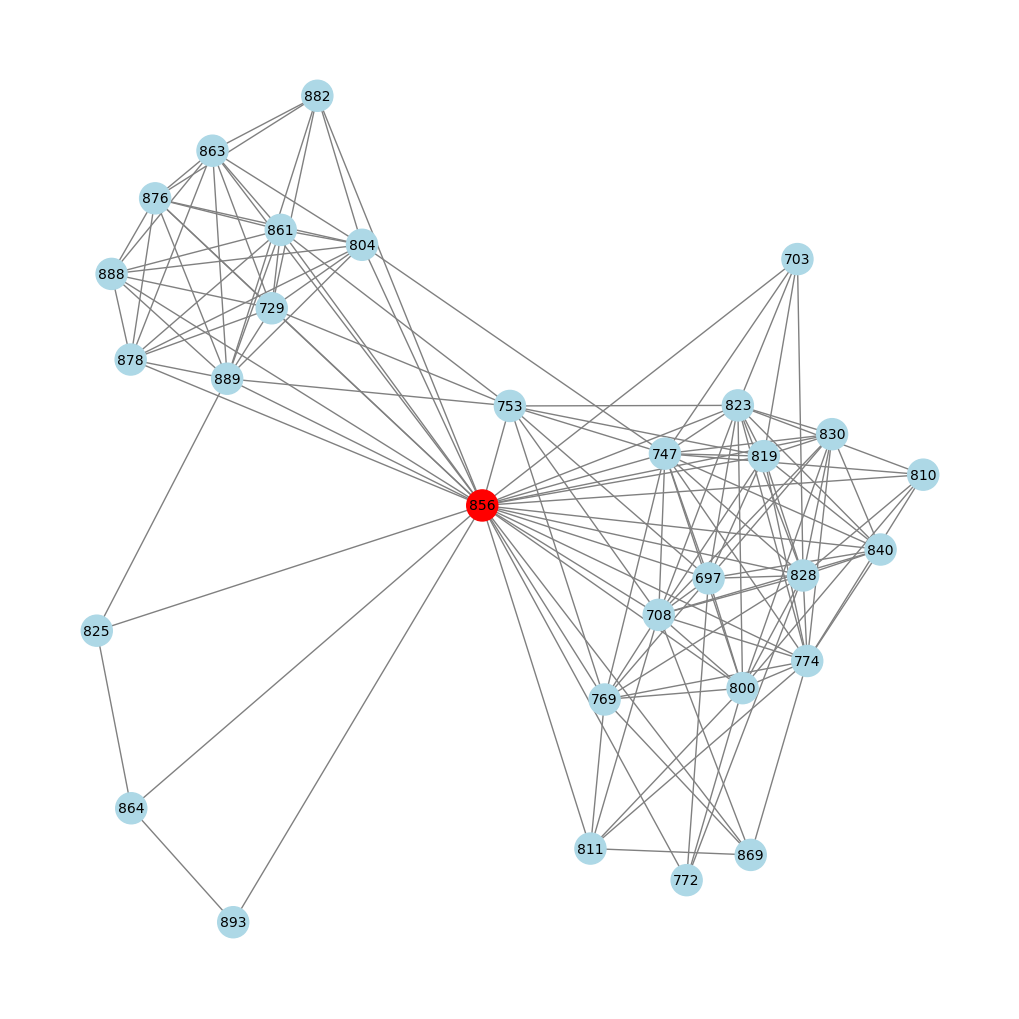

In [345]:
visualizar_nodo_alrededor(edges_dict["698"], 856, 1)

Un nodo usuario con alta "Degree Centrality" y "Eigenvector Centrality" en un grafo puede ser ideal para recomendaciones de amistad en una red social por las siguientes razones:

1. **Degree Centrality**: Este nodo tiene muchas conexiones directas con otros nodos. Un usuario con alta "Degree Centrality" es popular y bien conectado, lo que indica que tiene una alta probabilidad de interacción social y puede ser un puente entre diferentes grupos de usuarios. Recomendarlo como amigo puede facilitar la expansión de la red social del usuario, proporcionando más oportunidades de interacción y amistad.

2. **Eigenvector Centrality**: Este nodo no solo tiene muchas conexiones, sino que también está conectado a otros nodos importantes y bien conectados. Un usuario con alta "Eigenvector Centrality" es influyente y central dentro de la estructura de la red. Conectar con este usuario puede proporcionar acceso a una red más amplia e influyente, mejorando el alcance y las oportunidades dentro de la red social.

**Detección de comunidades**

Se utilizará el algoritmo Greedy Modularity Maximization:

Este algoritmo de maximización de modularidad "greedy" para la detección de comunidades en grafos comienza con cada nodo en su propia comunidad. Luego, iterativamente, combina comunidades que resultan en el mayor aumento de la modularidad total del grafo, un valor que mide la densidad de enlaces dentro de comunidades comparada con enlaces entre comunidades. Este proceso continúa hasta que no se pueden hacer más fusiones que incrementen la modularidad, proporcionando una partición del grafo en comunidades optimizadas por modularidad.

In [348]:
communities_dict = {}
for i in node_ids:
    communities = nx.community.greedy_modularity_communities(edges_dict[i])
    communities_dict[i] = communities
    print("Comunidades detectadas para nodo ego {}: {}".format(i, communities))

Comunidades detectadas para nodo ego 0: [frozenset({257, 258, 3, 261, 9, 10, 265, 268, 13, 270, 271, 16, 272, 274, 276, 21, 277, 280, 25, 26, 283, 285, 30, 288, 290, 291, 295, 39, 40, 297, 298, 45, 303, 304, 50, 311, 55, 56, 313, 314, 315, 60, 59, 318, 63, 62, 65, 322, 66, 323, 69, 67, 325, 72, 75, 331, 332, 76, 334, 79, 82, 85, 341, 342, 344, 345, 96, 98, 103, 104, 105, 109, 113, 118, 119, 121, 122, 123, 128, 132, 133, 134, 141, 142, 148, 153, 156, 158, 161, 165, 169, 170, 172, 176, 183, 185, 186, 188, 199, 200, 203, 207, 208, 211, 212, 221, 222, 223, 224, 228, 232, 234, 235, 236, 238, 239, 248, 250, 252}), frozenset({2, 262, 137, 138, 140, 14, 144, 17, 19, 20, 149, 279, 151, 28, 32, 289, 162, 293, 167, 41, 44, 174, 49, 305, 307, 52, 182, 310, 312, 192, 70, 71, 326, 205, 333, 337, 214, 343, 216, 220, 93, 97, 226, 230, 111, 112, 241, 243, 115, 116, 253, 255}), frozenset({1, 130, 5, 135, 266, 139, 24, 281, 284, 159, 164, 36, 299, 300, 302, 48, 180, 309, 53, 184, 57, 187, 316, 317, 191, 

Ahora se visualiza las comunidades detectadas en las redes ego

In [361]:
# Función para visualizar comunidades en grafos
# Input: Identificador de red ego
# Output: Gráfico con la comunidad de la red
def visualizar_comunidad(ego_id):
    color_map = {}
    for i, comm in enumerate(communities_dict[ego_id]):
        for node in comm:
            color_map[node] = i
    
    # Posiciones de los nodos
    pos = nx.spring_layout(edges_dict[ego_id])
    
    # Dibujar la red con nodos coloreados por comunidad
    plt.figure(figsize=(10, 6))
    nx.draw(
        edges_dict[ego_id],
        pos,
        node_color=[color_map[node] for node in edges_dict[ego_id].nodes()],
        cmap=plt.cm.rainbow,
        node_size=200,
        with_labels=True,
    )
    plt.title("Comunidades detectadas en la red del nodo ego {}".format(ego_id))
    plt.show()

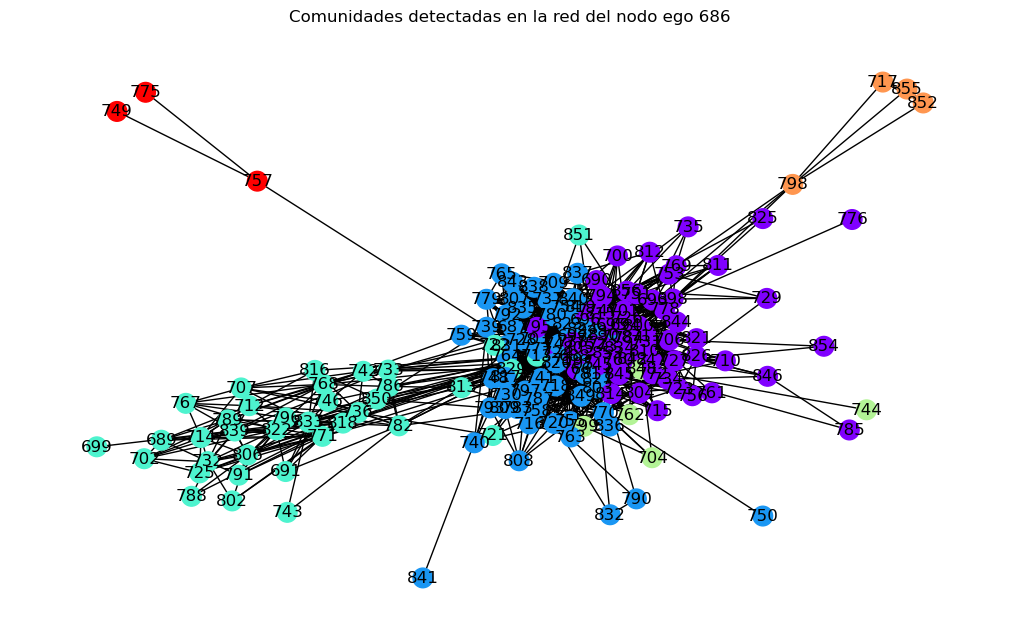

In [358]:
visualizar_comunidad("686")

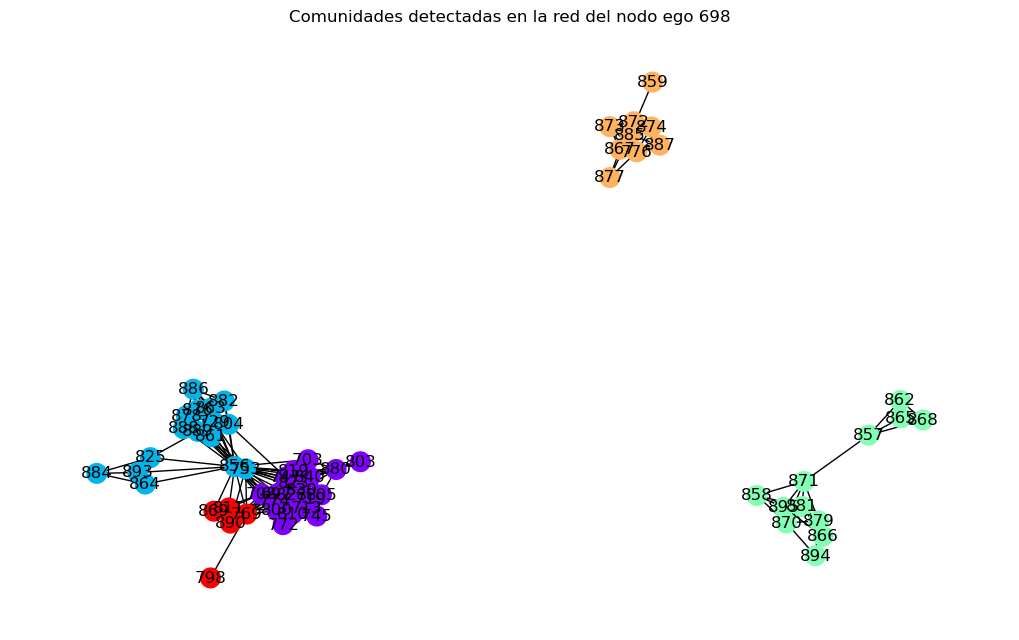

In [359]:
visualizar_comunidad("698")

Como se observa en las 2 gráficas previas, las comunidades se encargan de segregar a los usuarios en grupos "comunes". Esto puede aportar significativamente a la recomendación de amigos en las siguientes formas:

1. **Intereses comunes**:  Los miembros de una comunidad suelen compartir intereses o características comunes. Recomendar amigos dentro de la misma comunidad puede aumentar la probabilidad de que los usuarios tengan intereses similares, facilitando conexiones significativas.
   
2. **Conexiones Mutuas**: Los usuarios dentro de la misma comunidad tienen más probabilidades de tener conexiones mutuas. Aprovechar estas conexiones puede sugerir amigos que ya tienen un número considerable de amigos en común, aumentando la probabilidad de aceptación de la solicitud de amistad.


## Asociación de usuarios en base a features en común

La primera asociación que se va a analizar es en base a usuarios que cuenten con las mismas features en común.

Primero se vuelven a leer todos los datos "feat", "egofeat" y "featnames", para unir todo en una dataframe general.

In [3]:
node_ids = ["0", "107", "348", "414", "686", "698", "1684", "1912", "3437", "3980"]
df_dict = {}

# Lectura de feats y feat names para unirlos todos en un data frame
for i in node_ids:
    feat = read_feat("./facebook/" + i + ".feat")
    egofeat = read_egofeat("./facebook/" + i +".egofeat")
    featnames = read_featnames("./facebook/" + i + ".featnames")
    combined_df = create_combined_dataframe(feat, egofeat, featnames)
    df_dict[i] = combined_df

# Dataframe para evaluar las asociaciones
final_df = pd.concat([df_dict[x] for x in node_ids])
final_df.reset_index(inplace = True)
final_df.fillna(0, inplace = True)
final_df.drop(columns = ["index", "node"], inplace = True)

# Dataframe 2 para evaluar la recomendación de amigos
final_df_2 = pd.concat([df_dict[x] for x in node_ids])
final_df_2.reset_index(inplace = True)
final_df_2.fillna(0, inplace = True)
final_df_2.drop(columns = ["index"], inplace = True)

C:\Users\rober\AppData\Local\Temp\ipykernel_32904\1000597651.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df.reset_index(inplace = True)
C:\Users\rober\AppData\Local\Temp\ipykernel_32904\1000597651.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df_2.reset_index(inplace = True)


Debido a que se cuenta con una gran cantidad de features, estos se van a reducir a los más importantes; es decir, a los que más aporten para poder relacionar a dos o más personas.

Se considerarán los features que involucren lo siguiente:

- Education degree: Grado de educación
- Education school: Escuela de educación
- Hometown: Ciudad natal
- Location: Ubicación
- Work Location: Ubicación de trabajo
- Work Position: Posición de trabajo
- Work Project: Proyectos de trabajo
- Work Employer: Empleador de trabajo

In [4]:
features_chosen = ["education degree", "education school", "hometown", "location", "work location", "work position", "work project", "work employer"]
new_features = []

# Iteramos en todas las features disponibles y elegimos solo las que tengan relación con las elegidas

for feat_df in final_df.columns.tolist():
    for feat in features_chosen:
        if feat in feat_df:
            new_features.append(feat_df)     
            break

In [5]:
print("Iniciamente se tenían {} features".format(final_df.shape[1]))

Iniciamente se tenían 1406 features


In [6]:
final_df = final_df[new_features]
new_features_2 = new_features.copy()
new_features_2.append("node")
final_df_2 = final_df_2[new_features_2]

print("Ahora se tienen {} features".format(final_df.shape[1]))

Ahora se tienen 797 features


In [7]:
# Función para obtener en un array las features del usuario

def obtenerFeatures(nodo):
    feat_list = []
    for feature in final_df_2.columns.tolist():
        if final_df_2.loc[final_df_2[final_df_2["node"] == nodo].index, feature].values[0] == 1:
            feat_list.append(feature)
    if "node" in feat_list:
        feat_list.remove("node")
    return feat_list        

Para la asociación en base a features en común se usará un umbral de 6 features en común, como mínimo. 

Debido a la gran cantidad de usuarios (más de 4000), se hará un muestreo random para realizar este análisis inicial. Se trabajan con 1000 usuarios.

In [8]:
sample_df = final_df_2.sample(n=1000)

In [9]:
# Función para guardar los features de cada nodo en un diccionario
def save_feat_node_dict(df):
    dict_features_nodos = {}
    for nodo in df["node"]:
    # Ignoramos los nodos egos
        if nodo == "ego":
            pass
        else:
            dict_features_nodos[nodo] = obtenerFeatures(nodo)
    return dict_features_nodos

In [10]:
feat_nodos_dict_samp = save_feat_node_dict(sample_df)

In [11]:
feat_nodos_dict_samp

{2015: [],
 740: ['education school 340', 'education school 344', 'location 359'],
 606: ['education school 52',
  'location 129',
  'work employer 151',
  'education degree 223',
  'education school 317',
  'hometown 298'],
 828: ['education school 340',
  'education school 341',
  'education school 342',
  'hometown 359',
  'location 359',
  'work location 359'],
 2308: ['education school 789',
  'education school 811',
  'hometown 908',
  'location 558',
  'work location 558'],
 1764: ['hometown 84',
  'education school 228',
  'education school 237',
  'education school 247',
  'location 84',
  'work employer 518',
  'work location 84'],
 77: ['education school 44',
  'education school 50',
  'location 137',
  'work employer 150',
  'work position 193'],
 2095: ['education school 789', 'education school 863'],
 1597: [],
 1613: ['education school 538'],
 107: ['education degree 22', 'education school 52'],
 804: ['education school 345',
  'education school 348',
  'hometown 359',
 

In [12]:
# Función para relacionar a dos usuarios en base a características en común

# feat_nodos_dict: diccionario de nodos con sus características
def find_com_users(feat_nodos_dict, n):

    # Diccionario de usuarios con características en común
    associations = {}

    # Usuarios que serán comparados
    ids = list(feat_nodos_dict.keys())
    
    # Comparamos pares de personas
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            id1, id2 = ids[i], ids[j]
            features1, features2 = set(feat_nodos_dict[id1]), set(feat_nodos_dict[id2])
            
            # Características comunes
            common_features = features1.intersection(features2)

            # Verificamos si hay n o más features en común
            if len(common_features) >= n:
                associations[(id1, id2)] = list(common_features)

    return associations

Se buscan los usuarios que tengan 6 o más features en común.

In [21]:
users_6_com = find_com_users(feat_nodos_dict_samp, 6)

In [22]:
users_6_com

{(1549, 930): ['education school 52',
  'work position 182',
  'work location 128',
  'education degree 22',
  'education school 228',
  'work position 700',
  'work location 84',
  'work location 561',
  'location 128'],
 (1549, 641): ['education degree 223',
  'education school 52',
  'education degree 22',
  'education school 230',
  'location 128',
  'work employer 52'],
 (1549, 419): ['education degree 223',
  'education school 52',
  'hometown 84',
  'education degree 22',
  'education school 230',
  'location 128']}

Función para poder visualizar en grafos los usuarios que presenten 6 o más features en común.

In [23]:
from matplotlib.lines import Line2D

def visualize_common_features(associations):
    # Crear el grafo
    G = nx.Graph()

    # Añadir nodos y aristas al grafo
    for user, features in associations.items():
        for feature in features:
            G.add_node(user, bipartite=0)
            G.add_node(feature, bipartite=1)
            G.add_edge(user, feature)

    # Crear posiciones para los nodos
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Dibujar los nodos y las aristas
    plt.figure(figsize=(12, 8))
    
    # Dibujar nodos de usuarios
    user_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 0]
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='blue', node_size=1000, label="Usuarios")

    # Dibujar nodos de features
    feature_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 1]
    nx.draw_networkx_nodes(G, pos, nodelist=feature_nodes, node_color='red', node_size=1000, label="Features")

    # Dibujar las aristas
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Dibujar las etiquetas
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # Ajustar la visualización
    plt.title('Relaciones entre usuarios y features comunes', fontsize=16)
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Usuarios', markersize=15, markerfacecolor='blue'),
                   Line2D([0], [0], marker='o', color='w', label='Features', markersize=15, markerfacecolor='red')]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

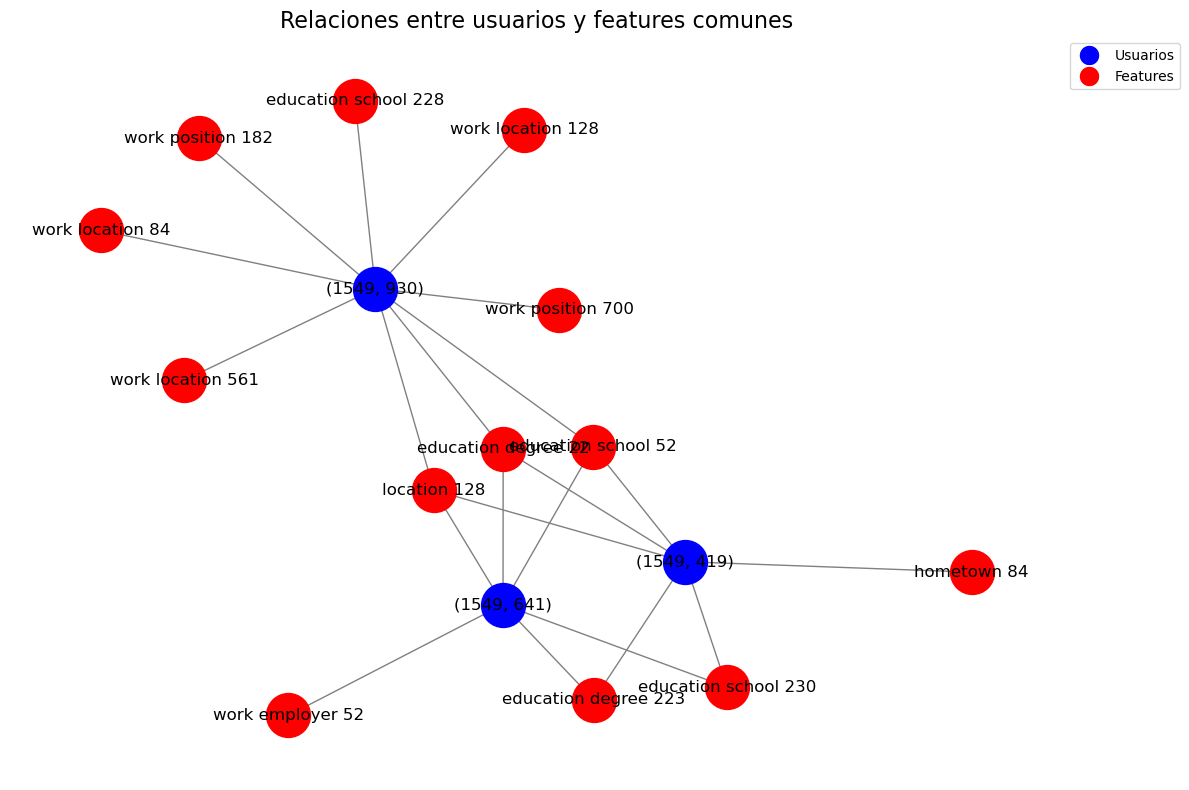

In [24]:
visualize_common_features(users_6_com)

De la gráfica previa se observa que los nodos azules vienen a ser los pares de usuarios con características en común, mientras que los nodos rojos a los que estos están conectados son las características en común que presentan.

## Aplicación del Algoritmo A-Priori

Ahora se utiliza el algoritmo Apriori para crear reglas de asociación que ayuden a generar recomendaciones de amigos, aprovechando que las filas representan usuarios de una red social y las columnas diferentes características binarias.

In [25]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules

In [26]:
# Hallamos las features más frecuentes y que cumplan con la condición dada (support > 0.01)
frequent_features = apriori(final_df, min_support = 0.01, use_colnames = True)

# Añadimos longitud del set
frequent_features["length"] = frequent_features["itemsets"].apply(lambda x:len(x))

C:\Users\rober\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [27]:
frequent_features.shape

(81, 3)

In [28]:
# Features o combinación de estos que presenten mayor frecuencia de aparición
frequent_features.sort_values(by = "support", ascending=False).head(10)

,support,itemsets,length
30,0.153699,(education school 538),1
3,0.113000,(education school 52),1
4,0.093129,(hometown 84),1
1,0.061767,(education degree 22),1
50,0.055542,(hometown 908),1
31,0.050754,(location 84),1
5,0.046445,(location 128),1
23,0.045727,(education school 228),1
58,0.043333,"(education school 52, location 128)",2
2,0.041657,(education school 50),1


In [29]:
frequent_features["length"].value_counts()

length
1    53
2    26
3     2
Name: count, dtype: int64

El algoritmo apriori, en base a la métrica support (>0.01), calculó los features con más frecuencia, siendo estos en total 81. Del total, 53, 26 y 2 presentan una longitud de 1, 2 y 3, correspondientemente.

De los 10 features más comunes, se observa que los de tipo "education school" son los más frecuentes, seguidos del tipo "location".

Ahora visualizamos los features más frecuentes de longitud 2, ordenados por support, de mayor a menor.

In [30]:
# Verificamos los features set de tamaño 2. Los ordenamos por support, de mayor a menor
frequent_features[frequent_features['length']==2].sort_values('support', ascending=False).head(10)

,support,itemsets,length
58,0.043333,"(education school 52, location 128)",2
73,0.035432,"(education school 538, location 617)",2
65,0.027053,"(hometown 84, location 84)",2
62,0.021307,"(hometown 84, education school 228)",2
74,0.019871,"(education school 1040, hometown 935)",2
57,0.019631,"(hometown 84, education school 52)",2
64,0.019392,"(education school 538, hometown 84)",2
60,0.018674,"(education school 52, education school 228)",2
78,0.017716,"(hometown 908, location 908)",2
53,0.017477,"(education degree 22, education school 52)",2


Se observa que la combinación con más frecuencia tiene que ver con "location" o "hometown" y "education school". Esta relación tiene bastante sentido que sea la que más se repita, porque las personas tienden a ir a escuelas que les quede en su misma ubicación de donde viven ("location") o en el mismo lugar donde crecieron ("hometown"), en caso no se hayan mudado.

In [31]:
# Verificamos los features set de tamaño 3
frequent_features[frequent_features['length']==3].sort_values('support', ascending=False)

,support,itemsets,length
79,0.011492,"(hometown 84, education school 52, location 128)",3
80,0.010534,"(hometown 84, education school 52, education s...",3


Text(0.5, 1.0, "Distribución de 'support'")

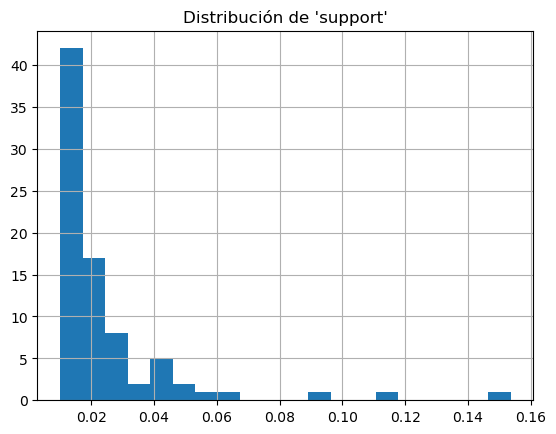

In [33]:
# Visualizamos la distribución de "support" en un histograma
frequent_features['support'].hist(bins=20)
plt.title("Distribución de 'support'")

Ahora se procede a crear las reglas de asociación con la métrica lift (mínimo de 1.2).

In [34]:
rules = association_rules(frequent_features, metric="lift", min_threshold=1.2)

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
#Visualización en base al lift
rules.sort_values("lift",ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
43,(hometown 935),(education school 1040),0.030405,0.027771,0.019871,0.653543,23.533193,0.019026,2.806206,0.987532,1,1
42,(education school 1040),(hometown 935),0.027771,0.030405,0.019871,0.715517,23.533193,0.019026,3.408275,0.984857,1,1
6,(education school 50),(location 137),0.041657,0.011013,0.010055,0.241379,21.918291,0.009596,1.303665,0.995860,1,1
7,(location 137),(education school 50),0.011013,0.041657,0.010055,0.913043,21.918291,0.009596,11.020948,0.965003,1,1
4,(education school 50),(location 132),0.041657,0.012689,0.011492,0.275862,21.741054,0.010963,1.363430,0.995472,1,1
5,(location 132),(education school 50),0.012689,0.041657,0.011492,0.905660,21.741054,0.010963,10.158439,0.966265,1,1
34,(education school 537),(location 619),0.032080,0.016519,0.011492,0.358209,21.684620,0.010962,1.532401,0.985500,1,1
35,(location 619),(education school 537),0.016519,0.032080,0.011492,0.695652,21.684620,0.010962,3.180307,0.969906,1,1
45,(location 935),(education school 1040),0.018674,0.027771,0.010773,0.576923,20.774204,0.010255,2.297996,0.969976,1,1
44,(education school 1040),(location 935),0.027771,0.018674,0.010773,0.387931,20.774204,0.010255,1.603294,0.979053,1,1


In [35]:
rules.shape

(64, 12)

De la tabla previa se observan las diferentes métricas de asociación, entre las más importantes se tienen:

-Support: Mide la proporción de usuarios en el conjunto de datos que contienen las características antecedentes y consecuentes.

-Confidence: Mide la probabilidad de que el consecuente aparezca dado que el antecedente está presente.

-Lift: Mide la importancia de la regla en términos de la dependencia entre el antecedente y el consecuente. Un lift mayor a 1 indica que el
antecedente y consecuente están positivamente correlacionados.

In [36]:
# Visualización en base al Confidence
rules.sort_values("confidence",ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
11,(location 128),(education school 52),0.046445,0.113000,0.043333,0.932990,8.256563,0.038084,13.236773,0.921692,1,1
53,"(hometown 84, location 128)",(education school 52),0.012449,0.113000,0.011492,0.923077,8.168840,0.010085,11.531003,0.888646,2,1
7,(location 137),(education school 50),0.011013,0.041657,0.010055,0.913043,21.918291,0.009596,11.020948,0.965003,1,1
41,(location 617),(education school 538),0.039023,0.153699,0.035432,0.907975,5.907498,0.029434,9.196473,0.864458,1,1
5,(location 132),(education school 50),0.012689,0.041657,0.011492,0.905660,21.741054,0.010963,10.158439,0.966265,1,1
42,(education school 1040),(hometown 935),0.027771,0.030405,0.019871,0.715517,23.533193,0.019026,3.408275,0.984857,1,1
35,(location 619),(education school 537),0.016519,0.032080,0.011492,0.695652,21.684620,0.010962,3.180307,0.969906,1,1
20,(education school 232),(hometown 84),0.018195,0.093129,0.012449,0.684211,7.346908,0.010755,2.871758,0.879898,1,1
43,(hometown 935),(education school 1040),0.030405,0.027771,0.019871,0.653543,23.533193,0.019026,2.806206,0.987532,1,1
46,(education school 789),(hometown 908),0.019392,0.055542,0.012210,0.629630,11.336047,0.011133,2.550036,0.929817,1,1


De la tabla previa se observa que si una persona pertenece "location 128", existe un 93% de probabilidades de que vaya a "education school 52", esto puede indicarnos de que esa escuela es muy popular en "location 128". Por lo tanto, se crearía una recomendación de amigos de una persona que cuente con el "location 128" con alguien que vaya a "education school 52".

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Función para visualizar las reglas de asociación
def visualize_rules(rules):
    G = nx.Graph()

    # Añadimos nodos y edges de las reglas
    for _, row in rules.iterrows():
        antecedent = tuple(row['antecedents'])
        consequent = tuple(row['consequents'])
        G.add_node(antecedent, color='blue', size=300)
        G.add_node(consequent, color='red', size=300)
        G.add_edge(antecedent, consequent, weight=row['lift'])

    # Obtenemos posiciones para los nodos en el grafo
    pos = nx.spring_layout(G, k=2)
    
    # Extraemos los colores de los nodos y sus tamaños
    node_colors = [G.nodes[node]['color'] for node in G.nodes]
    node_sizes = [G.nodes[node]['size'] for node in G.nodes]
    
    # Extraemos el peso de los edges
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    
    # Dibujamos grafo
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, 
            font_size=10, font_color='black', edge_color=edge_weights, edge_cmap=plt.cm.Blues, width=2)
    
    # Dibujamos la etiqueta de los edges
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # Leyenda
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Antecedente',
                                  markersize=10, markerfacecolor='blue'),
                       plt.Line2D([0], [0], marker='o', color='w', label='Consecuente',
                                  markersize=10, markerfacecolor='red')]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.title('Reglas de Asociación Visualizadas en Grafos')
    plt.show()

C:\Users\rober\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:304: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


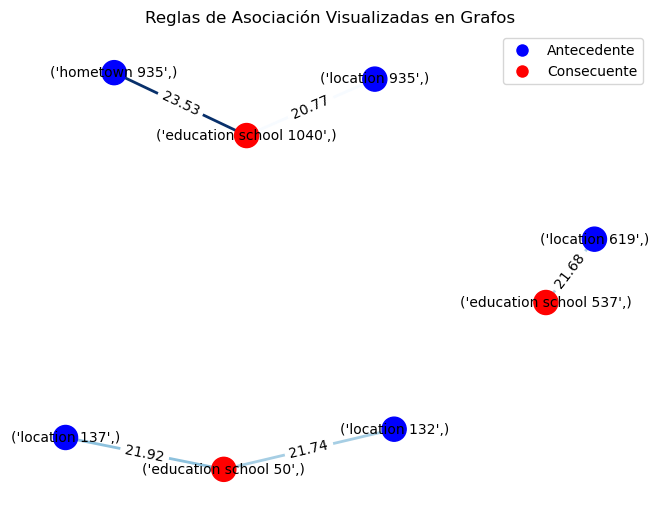

In [38]:
# Filtramos las reglas de asociación con lift > 15 para obtener relaciones significativas
filtered_rules = rules[rules['lift'] > 15]

# Visualizamos las reglas filtradas
visualize_rules(filtered_rules)

Ahora se van a utilizar las reglas de asociación obtenidas para recomendar amigos a los usuarios.

In [126]:
# Función para buscar usuarios en base a 1 o más features
# Inputs: features y diccionario de features donde los key son los usuarios y los valores una lista de sus features respectivas
# Outputs: lista de usuarios que cumplen el requisito inicial de los features buscados
def search_user_feat(features, features_dict):
    list_usuarios_feat = [] # Lista de usuarios con los features requeridos
    for i in features_dict.keys():
        cont_feat = 0
        for j in features:
            if j in features_dict[i]:
                cont_feat = cont_feat + 1
            else:
                break
        if cont_feat == len(features):
            list_usuarios_feat.append(i)
    return list_usuarios_feat

In [127]:
# Se cargan los grafos respectivos para cada user ego 
node_ids = ["0", "107", "348", "414", "686", "698", "1684", "1912", "3437", "3980"]
graph_dict = {}
for i in node_ids:
    graph = read_edges("./facebook/" + i + ".edges")
    graph_dict[i] = graph

In [128]:
# Función para verificar previamente si dos usuarios son amigos
# Inputs: los ID del usuario principal y de su posible nuevo amigo
# Output: Devuelve True si los dos usuarios son amigos, y False si no son amigos
def are_friends(user_id, potential_friend_id):
    for i in graph_dict.keys():
        if graph_dict[i].has_edge(user_id, potential_friend_id):
            return True
    return False

In [135]:
# Función para recomendar amigos
# Inputs: usuario del ID al que se le busca amigo, diccionario con las features de cada usuario y las reglas de asociación
# False: Devuelve un set de user ids de usuarios que cumplan con las reglas de asociación y no sean amigos con el user principal
def recommend_friends(user_id, dict_feat, rules):
    # Obtener las características del usuario
    user_features = dict_feat[user_id]
    recommendations = set() # Recomendación de ID de nuevos amigos
    
    # Recorrer todas las reglas de asociación
    for _, rule in rules.iterrows():
        antecedents = rule['antecedents']
        consequents = rule['consequents']
        
        # Verificar si el usuario cumple con las características de los antecedentes
        num_antecedents = 0
        for antecedent in antecedents:
            if antecedent in user_features:
                num_antecedents = num_antecedents + 1
            else:
                pass
        if (num_antecedents == len(antecedents)):
            recommended_features = list(consequents)
        
            # Buscar a otros usuarios con las características recomendadas
            users_recommended = search_user_feat(recommended_features, dict_feat) 
            for user in users_recommended:
                if user == user_id:
                    pass
                else:
                    if are_friends(user_id, user): # Verificamos si el usuario principal ya es amigo del usuario recomendado
                        pass
                    else:
                        recommendations.add(user)
        
    return recommendations

In [161]:
# Cantidad de recomendación de amigos para los usuarios sampleados
# Se va a filtrar las rules para considerar solo lift > 15
new_rules = rules[rules["lift"]> 15]
num_recom_friends = [] # lista para guardar la cantidad de amigos que se les recomienda a cada usuario
for i in feat_nodos_dict_samp.keys():
    num_recom_friends.append(len(recommend_friends(i, feat_nodos_dict_samp, new_rules)))
    if len(recommend_friends(i, feat_nodos_dict_samp, new_rules)) > 10:
        print("El usuario {}, tiene {} recomendaciones de amigos".format(i, len(recommend_friends(i, feat_nodos_dict_samp, new_rules))))

El usuario 77, tiene 36 recomendaciones de amigos
El usuario 152, tiene 37 recomendaciones de amigos
El usuario 1443, tiene 28 recomendaciones de amigos
El usuario 3674, tiene 26 recomendaciones de amigos
El usuario 347, tiene 35 recomendaciones de amigos
El usuario 3552, tiene 24 recomendaciones de amigos
El usuario 2874, tiene 39 recomendaciones de amigos
El usuario 2924, tiene 33 recomendaciones de amigos
El usuario 2302, tiene 23 recomendaciones de amigos
El usuario 3399, tiene 27 recomendaciones de amigos
El usuario 3195, tiene 35 recomendaciones de amigos
El usuario 3827, tiene 16 recomendaciones de amigos
El usuario 3966, tiene 26 recomendaciones de amigos
El usuario 2782, tiene 26 recomendaciones de amigos
El usuario 180, tiene 35 recomendaciones de amigos
El usuario 209, tiene 24 recomendaciones de amigos
El usuario 2988, tiene 34 recomendaciones de amigos
El usuario 316, tiene 35 recomendaciones de amigos
El usuario 1322, tiene 16 recomendaciones de amigos
El usuario 2920, ti

Se procede a visualizar en un histograma la cantidad de amigos recomendados por usuario, considerando la regla de asociación con un lift > 15.

In [162]:
num_recom_friends_series = pd.Series(num_recom_friends)

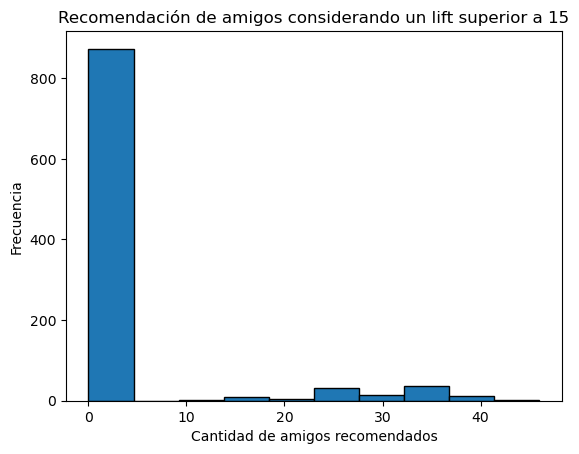

In [185]:
import matplotlib.pyplot as plt

plt.hist(num_recom_friends_series, bins = 10, edgecolor = 'black')
plt.xlabel("Cantidad de amigos recomendados")
plt.ylabel("Frecuencia")
plt.title("Recomendación de amigos considerando un lift superior a 15")
plt.show()

Se observa que la gran mayoría de usuarios no presentan recomendaciones de amigos, esto debido a que no presentan características presentes en la regla de asociación cuando el lift es mayor a 15.

In [168]:
num_recom_friends_series.describe()

count    987.000000
mean       3.375887
std        9.690837
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       46.000000
dtype: float64

In [173]:
(num_recom_friends_series>1).value_counts()

False    873
True     114
Name: count, dtype: int64

Solo 114 usuarios tienen de recomendación por lo menos a 1 usuario, el resto (873), no presentan recomendaciones de amigos cuando Lift > 15.

Ahora se hará un análisis similar pero para un Lift > 10.

In [175]:
# Cantidad de recomendación de amigos para los usuarios sampleados
# Se va a filtrar las rules para considerar solo lift > 5
new_rules_5 = rules[rules["lift"]> 5]
num_recom_friends_5 = [] # lista para guardar la cantidad de amigos que se les recomienda a cada usuario
for i in feat_nodos_dict_samp.keys():
    num_recom_friends_5.append(len(recommend_friends(i, feat_nodos_dict_samp, new_rules_5)))
    if len(recommend_friends(i, feat_nodos_dict_samp, new_rules_5)) > 10:
        print("El usuario {}, tiene {} recomendaciones de amigos".format(i, len(recommend_friends(i, feat_nodos_dict_samp, new_rules_5))))

El usuario 606, tiene 90 recomendaciones de amigos
El usuario 2308, tiene 52 recomendaciones de amigos
El usuario 1764, tiene 131 recomendaciones de amigos
El usuario 77, tiene 36 recomendaciones de amigos
El usuario 2095, tiene 39 recomendaciones de amigos
El usuario 1613, tiene 30 recomendaciones de amigos
El usuario 107, tiene 50 recomendaciones de amigos
El usuario 2570, tiene 38 recomendaciones de amigos
El usuario 1314, tiene 56 recomendaciones de amigos
El usuario 678, tiene 131 recomendaciones de amigos
El usuario 152, tiene 37 recomendaciones de amigos
El usuario 1494, tiene 156 recomendaciones de amigos
El usuario 1443, tiene 118 recomendaciones de amigos
El usuario 3674, tiene 26 recomendaciones de amigos
El usuario 1853, tiene 176 recomendaciones de amigos
El usuario 2190, tiene 37 recomendaciones de amigos
El usuario 347, tiene 35 recomendaciones de amigos
El usuario 1349, tiene 120 recomendaciones de amigos
El usuario 396, tiene 131 recomendaciones de amigos
El usuario 35

In [176]:
num_recom_friends_series_5 = pd.Series(num_recom_friends_5)

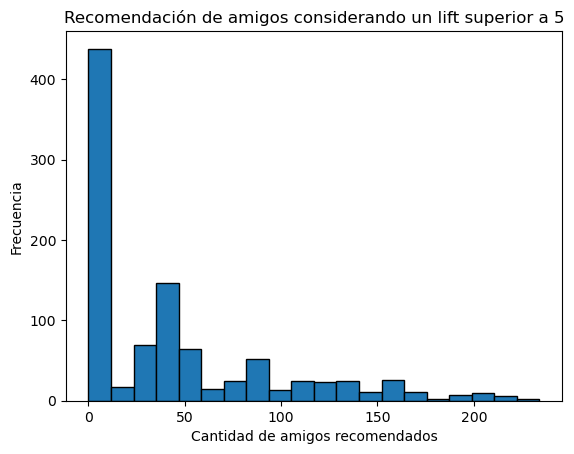

In [183]:
import matplotlib.pyplot as plt

plt.hist(num_recom_friends_series_5, bins = 20, edgecolor = 'black')
plt.xlabel("Cantidad de amigos recomendados")
plt.ylabel("Frecuencia")
plt.title("Recomendación de amigos considerando un lift superior a 5")
plt.show()

Se observa que la cantidad de usuarios con recomendaciones de amigos aumenta cuando la regla de asociación en base al lift se reduce de 15 a 5.

In [179]:
num_recom_friends_series_5.describe()

count    987.000000
mean      43.015198
std       53.558888
min        0.000000
25%        0.000000
50%       32.000000
75%       62.000000
max      234.000000
dtype: float64

In [181]:
(num_recom_friends_series_5>1).value_counts()

True     549
False    438
Name: count, dtype: int64

Cuando se condiera las reglas de asociación con un lift superior a 5, 549 usuarios cuentan con, por lo menos, 1 recomendación de amigos, mientras que 438 siguen sin presentar recomendaciones de amigos.

Ahora se procede a visualizar la recomendación de amigos en forma de grafos.

In [192]:
import networkx as nx
import matplotlib.pyplot as plt

# Función para visualizar las recomendaciones de amigos en grafos
# Inputs: id del usuario al que se le recomendará amigos y un set con el id de sus amigos recomendados
# Outputs: gráfica de grafos
def visualize_recommendations(user_id, recommendations):
    # Crear un nuevo grafo
    G = nx.Graph()
    
    # Añadir el nodo central (usuario principal)
    G.add_node(user_id, color='blue', size=500, label=str(user_id))
    
    # Añadir nodos de recomendaciones y edges entre el usuario principal y las recomendaciones
    for friend_id in recommendations:
        G.add_node(friend_id, color='red', size=300, label=str(friend_id))
        G.add_edge(user_id, friend_id)
    
    # Obtener los colores y tamaños de los nodos
    node_colors = [G.nodes[node]['color'] for node in G.nodes]
    node_sizes = [G.nodes[node]['size'] for node in G.nodes]
    labels = {node: G.nodes[node]['label'] for node in G.nodes}
    
    # Generar posiciones para los nodos
    pos = nx.spring_layout(G)
    
    # Dibujar el grafo
    nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_colors, node_size=node_sizes,
            font_size=10, font_color='black', edge_color='gray', width=2)
    
    # Leyenda
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Usuario Principal',
                                  markersize=10, markerfacecolor='blue'),
                       plt.Line2D([0], [0], marker='o', color='w', label='Recomendación de Amigos',
                                  markersize=10, markerfacecolor='red')]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.title('Recomendaciones de Amigos para nodo {}'.format(user_id))
    plt.show()

In [190]:
# Hacemos la prueba para el nodo 3876 y 3433, considerando la regla de asociación Lift > 15
friends_recom_3876 = recommend_friends(3876, feat_nodos_dict_samp, new_rules)
friends_recom_3433 = recommend_friends(3433, feat_nodos_dict_samp, new_rules)

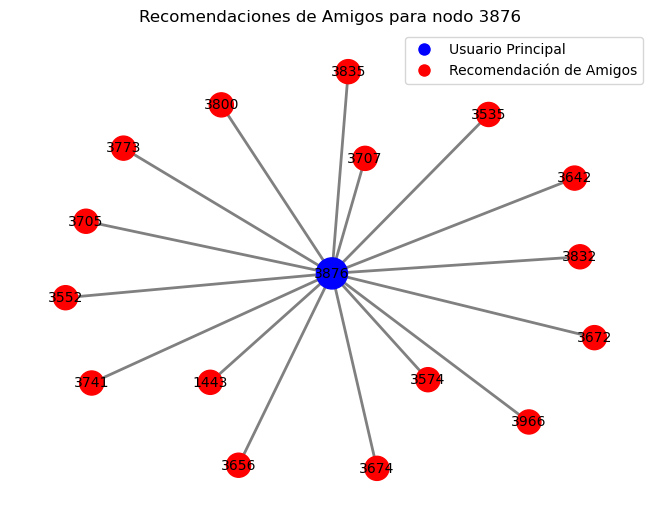

In [193]:
visualize_recommendations(3876, friends_recom_3876)

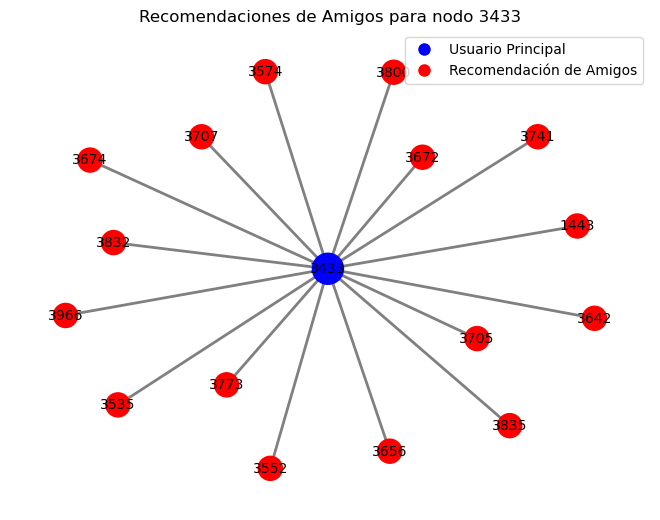

In [194]:
visualize_recommendations(3433, friends_recom_3876)

## Conclusiones

En resumen, se presentan las siguientes conclusiones en base a la recomendación de amigos en una red social con el uso de análisis de grafos y la utilización del algoritmo a priori y sus métricas:

1. **Mejor experiencia de usuario**: Al recomendar amigos con intereses comunes o conexiones compartidas, se facilita que los usuarios encuentren personas con las que es más probable que interactúen. Una red social que ayuda a los usuarios a encontrar amigos relevantes tiende a mantener a los usuarios más comprometidos y satisfechos.

2. **Crecimiento orgánico de la red social**: Las recomendaciones de amigos pueden incentivar a los usuarios a invitar a otros amigos y conocidos, promoviendo un crecimiento orgánico de la red. Al fortalecer las conexiones dentro de la red, se incrementa la densidad de la misma, haciendo que la red sea más robusta y valiosa para los usuarios.

3. **Algoritmo a priori y sus métricas**: El algoritmo Apriori permite descubrir patrones frecuentes en los datos de la red social, como grupos de usuarios con intereses compartidos o comportamientos similares. Sus métricas: support, confidence y lift, permiten encontrar las mejores asociaciones, además de poder seleccionar las asociaciones en base a estas.

4. **Medidas de centralidad en grafos y comunidades**: El uso de medidas de centralidad en grafos y la creación de comunidades mejora significativamente las recomendaciones de amigos en redes sociales. Las medidas de centralidad, como "Degree Centrality" y "Eigenvector Centrality", identifican usuarios bien conectados e influyentes, facilitando conexiones relevantes y expansivas. La detección de comunidades permite recomendar amigos con intereses comunes y conexiones mutuas, fomentando interacciones significativas. En conjunto, estos métodos aumentan la cohesión social y la satisfacción del usuario, optimizando la experiencia en la red social.

## Próximos pasos

1. Integración de Resultados de Apriori: Combinar los resultados del análisis de grafos con las reglas de asociación generadas por el algoritmo Apriori para enriquecer las recomendaciones. Evaluar cómo las características comunes (features) encontradas por Apriori pueden mejorar la precisión de las recomendaciones basadas en centralidad y comunidades.

2. Desarrollo de un Sistema de Recomendación Híbrido: Diseñar un sistema de recomendación que integre múltiples enfoques, combinando medidas de centralidad, detección de comunidades y reglas de asociación. Este sistema híbrido debe ponderar diferentes factores para generar recomendaciones equilibradas y personalizadas.

3. Monitoreo Continuo y Retroalimentación: Establecer mecanismos de monitoreo continuo para evaluar el desempeño del sistema y la aceptación por parte de los usuarios. Recopilar y analizar feedback de los usuarios para identificar áreas de mejora y realizar ajustes continuos en el sistema de recomendación.